## LAPP

LPP在选择k个最近邻时存在风险，因为原始数据集中存在噪音。如果错误确定了k个最近邻，整个算法的性能将降低。LAPP采用了一种从粗到细的策略，迭代LPP单元，直到找到满足少量噪声要求的最优子空间。LAPP的伪代码如下：

Input：$X= [x_1, x_2, x_3 ... x_m] \in \mathbb{R^{m \times n}}$，最终维度$d$，阈值$\delta$，最大迭代次数$T$。<br>
Output：变换矩阵$A \in \mathbb{R^{m \times d}}$。<br>
**1.** 计算相似矩阵S ($x_i$, $x_j$)。<br>
&emsp; 对于有监督学习，对于一个有$c$个标签的数据集，我们定义：
$$
S_{ij} = \left\{
\begin{aligned}
d(x_i,x_j), & \quad \text{if} \quad x_i \quad \text{and} \quad x_j \quad \text{belong to the same class}\\
0, & \quad \text{otherwise}
\end{aligned}
\right.
$$
&emsp;其中$d(x_i,x_j)$是$x_i$和$x_j$之间的权重。我们可以用用热核方式来计算权重：
$$
d(x_i,x_j) = \exp(-\frac{||x_i - x_j||^2}{2\sigma^2})
$$
&emsp;对于无监督学习，我们可以用以下方式计算相似矩阵：
$$
S_{ij} = \left\{
\begin{aligned}
d(x_i,x_j), & \quad \text{if} \quad x_i \quad \text{and} \quad x_j \quad \text{are k-nearest neighbors}\\
0, & \quad \text{otherwise}
\end{aligned}
\right.
$$
**2.** 根据相似矩阵S计算$S$，$D$和$L$。<br>
**3.** 解广义特征值问题，得到$A$。<br>
**4.** 迭代 = 0。<br>
**5.** __while__ iteration < T:  
&emsp;&emsp;&emsp;获取变换后的数据 $X_0 = A^TX$  
&emsp;&emsp;&emsp;$A_0 = A$  
&emsp;&emsp;&emsp;测量相似矩阵 S ($x_i$, $x_j$)  
&emsp;&emsp;&emsp;计算 $S$, $D$ and $L$  
&emsp;&emsp;&emsp;解广义特征值问题，得到$A$  
&emsp;&emsp;&emsp;__if__ diff($A - A_0$) < $\delta$:  
&emsp;&emsp;&emsp;&emsp;$A = A_0$, __break;__  
&emsp;&emsp;&emsp;__end if__  
iteration = iteration + 1  
__end while__
__return__ $A$<br>

In [211]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [212]:
def knn_graph(Data, method, k):
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_adjacency_matrix = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(n, distances): 
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

# 以将距离从小到大排序后的第k个距离作为每个数据点的半径
def compute_k_maximun_radius(n, distances, k):
    radius = np.zeros(n)
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    for i in range(n):
        # 选取第k个距离作为半径
        radius[i] = sorted_distances[i, k]
    return radius

# 计算k最近邻接矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix = np.zeros((n, n))
        radius = compute_k_maximun_radius(n, distances, k)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 获取epsilon邻域内的样本索引
            adjacency_matrix[i, neighbors] = 1
            adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, k, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    # 计算相似度矩阵
    similarity_matrix = np.exp(-distances ** 2 / t)
    # 将相似度矩阵按照邻接矩阵进行筛选，得到需要设置权重的位置
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    # 设置权重
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]  # 对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix   

def LPP(Data, d, method, k, t):
    # Step 1: 计算权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    transformation_matrix = (np.dot(selected_eigenvectors.T, Data)).T
    return transformation_matrix

In [213]:
# LAPP算法(无监督学习)
def LAPP(Data, d, method, k, t, max_iterations, delta):
    transformation_matrix = LPP(Data, d, method, k, t)
    for i in range(max_iterations):
        A_old = transformation_matrix
        X_new = (np.dot(A_old.T, Data.T)).T
        # 根据当前的变换矩阵A计算新的权重矩阵
        Weight_matrix = construct_weight_matrix(X_new, method, k, t)
        # 更新拉普拉斯矩阵
        Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
        Laplacian_matrix = Degree_matrix - Weight_matrix
        # 解广义特征值问题，得到新的变换矩阵A
        eigenvalues, eigenvectors = eigs(Laplacian_matrix, k=d+1, which='SR')
        sorted_indices = np.argsort(eigenvalues.real)
        selected_indices = sorted_indices[1:d + 1]
        A = eigenvectors.real[:, selected_indices]
        ## 检查迭代是否收敛
        diff = np.linalg.norm(A - A_old)
        if (diff < delta):
            break
    return A

In [214]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)

"\nplt.figure(figsize=(14, 10))\nk = 375\nt= 2700\nmax_iterations = 1\ndelta = 1e-0\nmethod = 'knn'\nA = LAPP(Data_T, d=2, method=method, k=k, t=t, max_iterations=max_iterations, delta=delta)\nlapp_embeddings = (np.dot(A.T, Data)).T\nplt.title('LAPP_ with k = ' + str(k) + ' and t = ' + str(t), size=25)\nplt.scatter(lapp_embeddings[:, 0], lapp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)\nplt.show()\n"

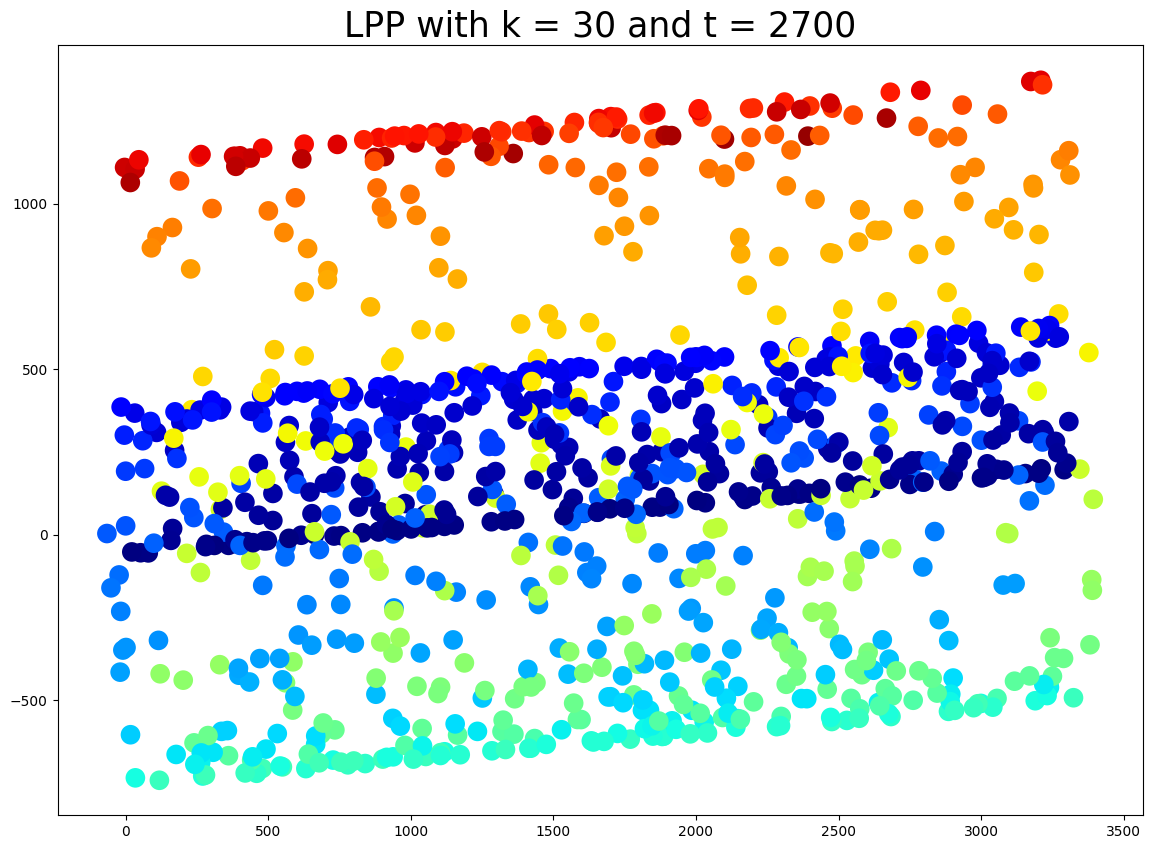

In [215]:
# LPP算法
plt.figure(figsize=(14, 10))
k = 30
t= 2700
method = 'knn'
A = LPP(Data_T, d=2, method=method, k=k, t=t)
lpp_embeddings = (np.dot(A.T, Data)).T
plt.title('LPP with k = ' + str(k) + ' and t = ' + str(t), size=25)
plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)

# LAPP算法
"""
plt.figure(figsize=(14, 10))
k = 375
t= 2700
max_iterations = 1
delta = 1e-0
method = 'knn'
A = LAPP(Data_T, d=2, method=method, k=k, t=t, max_iterations=max_iterations, delta=delta)
lapp_embeddings = (np.dot(A.T, Data)).T
plt.title('LAPP_ with k = ' + str(k) + ' and t = ' + str(t), size=25)
plt.scatter(lapp_embeddings[:, 0], lapp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
plt.show()
"""